<a href="https://colab.research.google.com/github/chemvatho/Peekbank-Analysis/blob/main/Peekbank_Complete_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Peekbank: Children's Word Recognition Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/peekbank-analysis/blob/main/Peekbank_Complete_Analysis.ipynb)

## Overview

This notebook provides a comprehensive analysis of the **Peekbank database** - an open repository of infant eye-tracking data from looking-while-listening experiments studying children's word recognition.

### What is Peekbank?

Peekbank aggregates data from multiple research labs studying how infants and toddlers recognize spoken words. The database contains:
- **39 datasets** from different research groups
- **3,537 children** tested
- **33+ million** eye-tracking timepoints
- Ages ranging from **6 to 84 months**

### The Looking-While-Listening Paradigm

```
┌─────────────────────────────────────────────────────────────────┐
│                                                                 │
│     🖼️ DOG                              🖼️ CAR                  │
│    (Target)                           (Distractor)             │
│                                                                 │
│                        👶                                       │
│                      (Child)                                    │
│                                                                 │
│                   🔊 "Look at the DOG!"                         │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

Children view two images while hearing a label. Eye-tracking measures how quickly and accurately they look to the named target.

### Citation

> Zettersten, M., Yurovsky, D., Xu, T. L., Urun, S., Meylan, S. C., Frank, M. C., ... & Marchman, V. A. (2022). **Peekbank: An open, large-scale repository for developmental eye-tracking data of children's word recognition.** *Behavior Research Methods*.

---

## 1. Setup and Installation

First, let's install the required packages and import libraries.

In [1]:
# Install required packages
!pip install mysql-connector-python pandas numpy matplotlib seaborn scipy -q

# Import libraries
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
import warnings
import os

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 56.9 MB/s eta 0:00:00
✓ Setup complete!


## 2. Database Connection

### Algorithm: Database Access

Peekbank provides public read-only access to their MySQL database. The connection parameters are:

| Parameter | Value |
|-----------|-------|
| Host | 34.210.173.143 |
| Port | 3306 |
| Database | 2025.1 |
| Username | reader |
| Password | gazeofraccoons |

The database uses a **relational schema** where tables are linked by IDs:

```
datasets ──┬── administrations ──┬── aoi_timepoints
           │                     │
           │                     └── trials ── trial_types ── stimuli
           │
           └── subjects
```

In [2]:
def connect_to_peekbank():
    """
    Establish connection to the Peekbank MySQL database.

    Returns:
        mysql.connector.connection: Active database connection
    """
    config = {
        'host': '34.210.173.143',
        'port': 3306,
        'database': '2025.1',
        'user': 'reader',
        'password': 'gazeofraccoons',
        'charset': 'utf8mb4'
    }

    try:
        conn = mysql.connector.connect(**config)
        print("✓ Successfully connected to Peekbank database!")
        print(f"  Server: {config['host']}")
        print(f"  Database version: {config['database']}")
        return conn
    except mysql.connector.Error as err:
        print(f"✗ Connection failed: {err}")
        return None

# Connect
conn = connect_to_peekbank()

✓ Successfully connected to Peekbank database!
  Server: 34.210.173.143
  Database version: 2025.1


## 3. Download and Save Data

### Algorithm: Data Retrieval

We download data using SQL queries that join related tables:

1. **Metadata tables** (small): datasets, subjects, stimuli, trial_types, administrations
2. **Eye-tracking data** (large): aoi_timepoints joined with administrations for age info

The key join is:
```sql
SELECT aoi.*, adm.age, adm.subject_id, adm.dataset_id
FROM aoi_timepoints aoi
JOIN administrations adm ON aoi.administration_id = adm.administration_id
```

In [3]:
# Create data directory
data_dir = 'peekbank_data'
os.makedirs(data_dir, exist_ok=True)

def download_and_save(conn, table_name, query=None, filename=None):
    """
    Download a table from Peekbank and save as CSV.

    Args:
        conn: Database connection
        table_name: Name of table or description
        query: SQL query (if None, selects all from table_name)
        filename: Output filename (if None, uses table_name)

    Returns:
        pandas.DataFrame: Downloaded data
    """
    if query is None:
        query = f"SELECT * FROM `{table_name}`"
    if filename is None:
        filename = table_name

    print(f"Downloading {table_name}...", end=" ")
    df = pd.read_sql(query, conn)

    filepath = f"{data_dir}/{filename}.csv"
    df.to_csv(filepath, index=False)
    print(f"✓ {len(df):,} rows saved to {filepath}")

    return df

# Download metadata tables
print("="*60)
print("DOWNLOADING METADATA TABLES")
print("="*60)

datasets = download_and_save(conn, 'datasets')
subjects = download_and_save(conn, 'subjects')
stimuli = download_and_save(conn, 'stimuli')
trial_types = download_and_save(conn, 'trial_types')
administrations = download_and_save(conn, 'administrations')
trials = download_and_save(conn, 'trials')

# Download eye-tracking data with age info
print("\n" + "="*60)
print("DOWNLOADING EYE-TRACKING DATA")
print("="*60)

aoi_query = """
SELECT aoi.*, adm.age, adm.subject_id, adm.dataset_id
FROM aoi_timepoints aoi
JOIN administrations adm ON aoi.administration_id = adm.administration_id
WHERE adm.age IS NOT NULL
LIMIT 1000000
"""
aoi_data = download_and_save(conn, 'aoi_timepoints (with age)', aoi_query, 'aoi_timepoints_sample')

print("\n✓ All data downloaded and saved!")

DOWNLOADING METADATA TABLES

DOWNLOADING EYE-TRACKING DATA

✓ All data downloaded and saved!


## 4. Data Overview

Let's explore the downloaded data to understand its structure.

DATA OVERVIEW

📊 DATASETS: 39 studies
   dataset_id               dataset_name                    shortcite
0           0      casillas_tseltal_2015       Casillas et al. (2017)
1           1               ronfard_2021  Ronfard, Wei, & Rowe (2021)
2           2               perry_cowpig       Perry & Saffran (2017)
3           3               pomper_yumme      Pomper & Saffran (2018)
4           4        pomper_saffran_2016      Pomper & Saffran (2016)
5           5         gazetriggered_2020          Egger et al. (2020)
6           6  nordmeyer_negtracker_2014     Nordmeyer & Frank (2014)
7           7              weisleder_stl   Weisleder & Fernald (2013)
8           8        adams_marchman_2018          Adams et al. (2018)
9           9             fernald_totlot        Fernald et al. (2006)

👶 SUBJECTS: 3,537 children

🎯 STIMULI: 1,582 unique items

📅 AGE DISTRIBUTION:
   Range: 6.0 - 83.8 months
   Mean: 26.3 months
   Median: 24.0 months


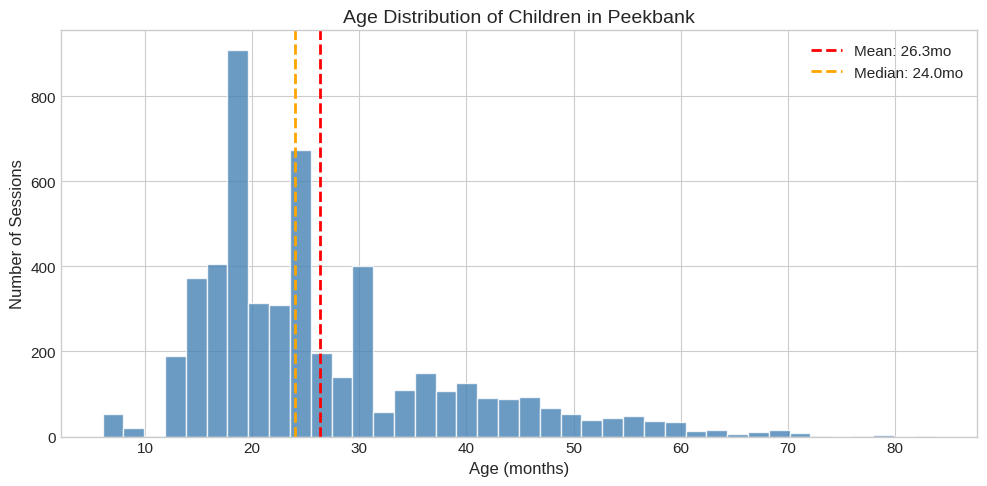

In [4]:
print("="*60)
print("DATA OVERVIEW")
print("="*60)

print(f"\n📊 DATASETS: {len(datasets)} studies")
print(datasets[['dataset_id', 'dataset_name', 'shortcite']].head(10).to_string())

print(f"\n👶 SUBJECTS: {len(subjects):,} children")
print(f"\n🎯 STIMULI: {len(stimuli):,} unique items")

# Age distribution
ages = administrations['age'].dropna()
print(f"\n📅 AGE DISTRIBUTION:")
print(f"   Range: {ages.min():.1f} - {ages.max():.1f} months")
print(f"   Mean: {ages.mean():.1f} months")
print(f"   Median: {ages.median():.1f} months")

# Plot age distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ages, bins=40, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(ages.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ages.mean():.1f}mo')
ax.axvline(ages.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {ages.median():.1f}mo')
ax.set_xlabel('Age (months)')
ax.set_ylabel('Number of Sessions')
ax.set_title('Age Distribution of Children in Peekbank')
ax.legend()
plt.tight_layout()
plt.savefig(f'{data_dir}/plot_age_distribution.png', dpi=150)
plt.show()

## 5. Data Preparation

### Algorithm: Computing Proportion Target Looking

The key dependent variable in looking-while-listening is **proportion target looking**:

$$\text{Prop. Target} = \frac{\text{Looks to Target}}{\text{Looks to Target} + \text{Looks to Distractor}}$$

This measure ranges from 0 to 1, where:
- **0.5** = chance (equal looking to both images)
- **> 0.5** = preference for target (word recognition)
- **< 0.5** = preference for distractor

The `aoi` column contains:
- `'target'` - looking at the named object
- `'distractor'` - looking at the other object
- `'other'` / `'missing'` - not looking at either

In [5]:
def prepare_looking_data(aoi_data):
    """
    Prepare eye-tracking data for analysis.

    Steps:
    1. Create binary target looking variable
    2. Identify valid looks (target or distractor only)
    3. Compute proportion target
    4. Create age groups for analysis

    Args:
        aoi_data: Raw AOI timepoint data

    Returns:
        pandas.DataFrame: Prepared data with computed measures
    """
    df = aoi_data.copy()

    # Step 1: Binary target looking (1 if target, 0 otherwise)
    df['target_looking'] = (df['aoi'] == 'target').astype(float)
    df['distractor_looking'] = (df['aoi'] == 'distractor').astype(float)

    # Step 2: Valid looks only (exclude missing/other)
    df['valid_look'] = df['aoi'].isin(['target', 'distractor'])

    # Step 3: Proportion target (NaN for invalid looks)
    df['prop_target'] = np.where(df['valid_look'], df['target_looking'], np.nan)

    # Step 4: Create age groups
    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 12, 18, 24, 36, 48, 100],
        labels=['6-12mo', '12-18mo', '18-24mo', '24-36mo', '36-48mo', '48+mo']
    )

    return df

# Prepare data
print("Preparing data...")
looking_data = prepare_looking_data(aoi_data)

print(f"\n✓ Prepared {len(looking_data):,} timepoints")
print(f"✓ Valid looks: {looking_data['valid_look'].sum():,} ({100*looking_data['valid_look'].mean():.1f}%)")
print(f"✓ Time range: {looking_data['t_norm'].min()} to {looking_data['t_norm'].max()} ms")

# Show AOI distribution
print("\n📊 AOI Distribution:")
print(looking_data['aoi'].value_counts().to_string())

Preparing data...

✓ Prepared 1,000,000 timepoints
✓ Valid looks: 729,673 (73.0%)
✓ Time range: -3300 to 6850 ms

📊 AOI Distribution:
aoi
target        436677
distractor    292996
missing       267777
other           2550


---

# 📈 Analysis Section

---

## Analysis 1: Time Course of Word Recognition

### Algorithm: Time Course Computation

The classic analysis in looking-while-listening plots **proportion target looking over time** relative to word onset:

1. **Filter** to analysis time window (typically -500 to 2000ms)
2. **Group by** time point (`t_norm`)
3. **Compute** mean proportion target at each time point
4. **Calculate** standard error: $SE = \frac{SD}{\sqrt{N}}$
5. **Plot** with 95% confidence intervals: $CI = \bar{x} \pm 1.96 \times SE$

### Key Time Points:
- **t = 0**: Target word onset
- **t ≈ 200-300ms**: Earliest possible saccade (minimum motor planning time)
- **t ≈ 300-500ms**: Earliest reliable word recognition effects
- **t ≈ 700-1000ms**: Peak looking to target

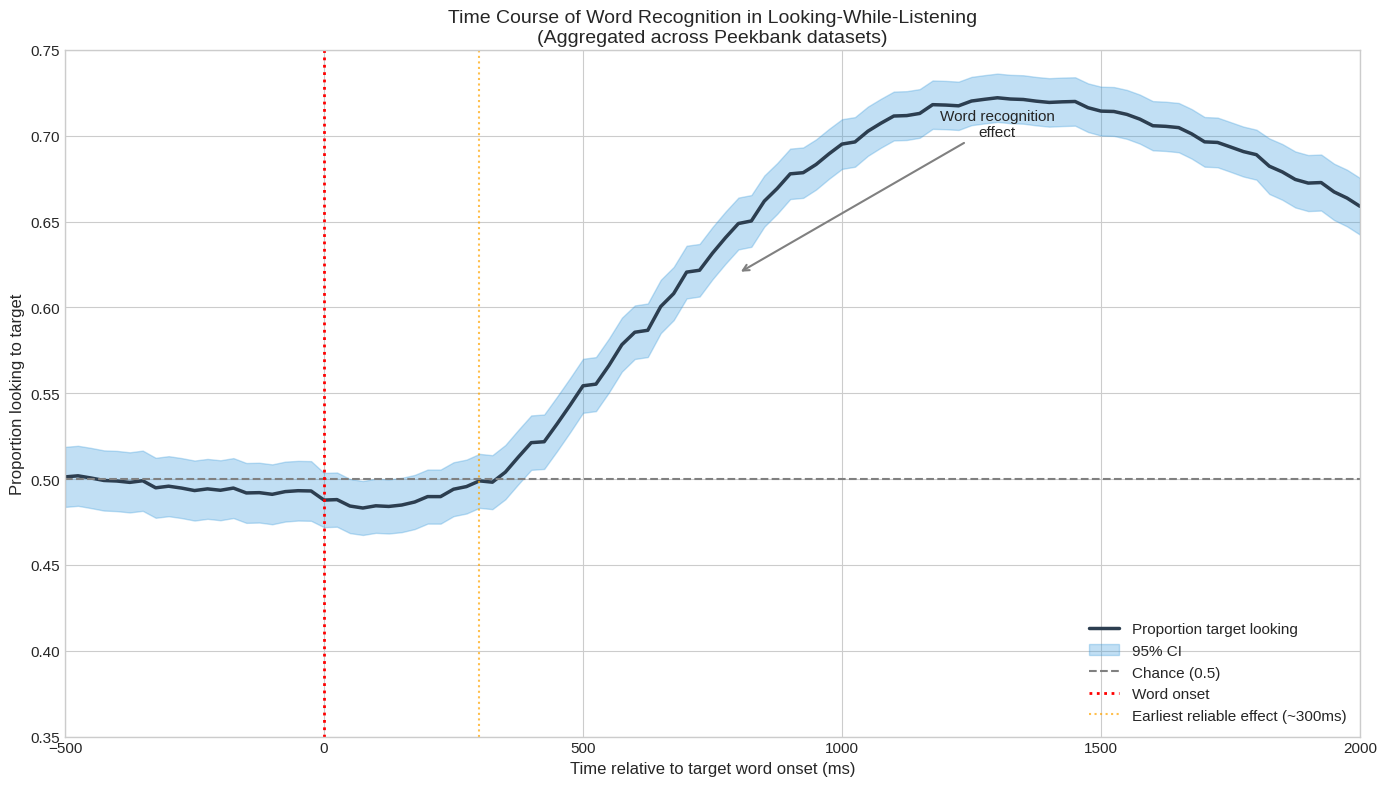


📊 TIME COURSE STATISTICS:
   Baseline (-500 to 0ms): 0.496
   Peak looking: 0.722 at 1300ms


In [6]:
def compute_time_course(data, time_window=(-500, 2000)):
    """
    Compute time course of target looking.

    Args:
        data: Prepared looking data
        time_window: Tuple of (start_ms, end_ms)

    Returns:
        pandas.DataFrame: Time course with mean, SE, and CI
    """
    # Filter to time window
    df = data[
        (data['t_norm'] >= time_window[0]) &
        (data['t_norm'] <= time_window[1])
    ].copy()

    # Compute statistics at each time point
    tc = df.groupby('t_norm').agg({
        'prop_target': ['mean', 'std', 'count']
    }).reset_index()
    tc.columns = ['time', 'mean', 'std', 'n']

    # Standard error and 95% CI
    tc['se'] = tc['std'] / np.sqrt(tc['n'])
    tc['ci_lower'] = tc['mean'] - 1.96 * tc['se']
    tc['ci_upper'] = tc['mean'] + 1.96 * tc['se']

    return tc

# Compute time course
time_course = compute_time_course(looking_data)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Main line
ax.plot(time_course['time'], time_course['mean'],
        color='#2C3E50', linewidth=2.5, label='Proportion target looking')

# 95% Confidence interval
ax.fill_between(time_course['time'],
                time_course['ci_lower'],
                time_course['ci_upper'],
                alpha=0.3, color='#3498DB', label='95% CI')

# Reference lines
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label='Chance (0.5)')
ax.axvline(x=0, color='red', linestyle=':', linewidth=2, label='Word onset')
ax.axvline(x=300, color='orange', linestyle=':', linewidth=1.5, alpha=0.7,
           label='Earliest reliable effect (~300ms)')

# Annotation
ax.annotate('Word recognition\neffect',
            xy=(800, 0.62), xytext=(1300, 0.70),
            fontsize=11, ha='center',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax.set_xlabel('Time relative to target word onset (ms)')
ax.set_ylabel('Proportion looking to target')
ax.set_title('Time Course of Word Recognition in Looking-While-Listening\n'
             '(Aggregated across Peekbank datasets)')
ax.set_xlim(-500, 2000)
ax.set_ylim(0.35, 0.75)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_time_course.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 TIME COURSE STATISTICS:")
print(f"   Baseline (-500 to 0ms): {time_course[time_course['time'] < 0]['mean'].mean():.3f}")
print(f"   Peak looking: {time_course['mean'].max():.3f} at {time_course.loc[time_course['mean'].idxmax(), 'time']:.0f}ms")

## Analysis 2: Developmental Changes

### Algorithm: Age Group Comparison

Key developmental predictions:
1. **Faster processing**: Older children show earlier shifts to target
2. **Higher accuracy**: Older children reach higher peak looking
3. **Steeper slopes**: Faster rate of increase in looking

We compute separate time courses for each age group and compare.

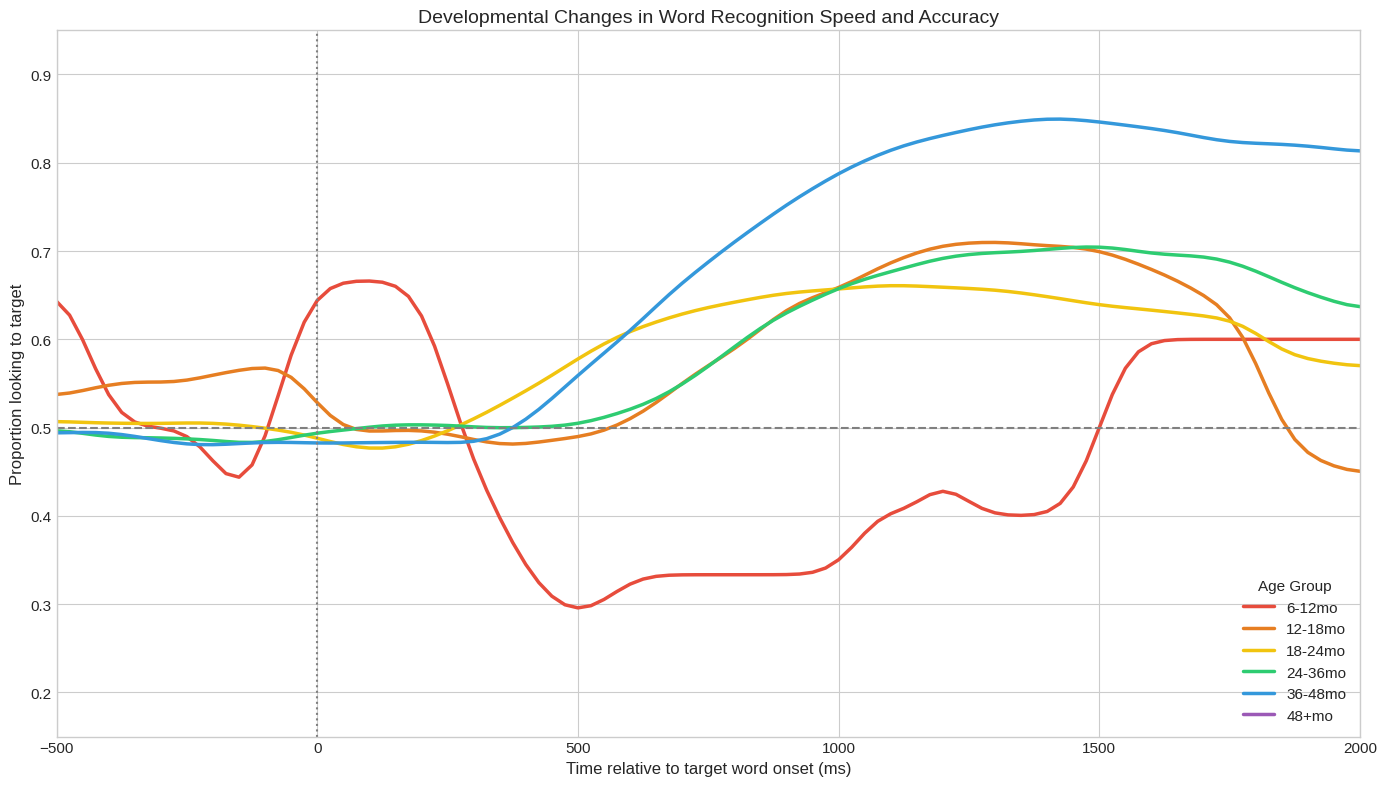

In [14]:
def compute_time_course_by_group(data, group_col, time_window=(-500, 2000)):
    """
    Compute time course separately for each group.

    Args:
        data: Prepared looking data
        group_col: Column name for grouping
        time_window: Analysis time window

    Returns:
        pandas.DataFrame: Time course by group
    """
    df = data[
        (data['t_norm'] >= time_window[0]) &
        (data['t_norm'] <= time_window[1]) &
        (data[group_col].notna())
    ].copy()

    tc = df.groupby([group_col, 't_norm'])['prop_target'].mean().reset_index()
    tc.columns = [group_col, 'time', 'mean']

    return tc

# Compute by age group
age_tc = compute_time_course_by_group(looking_data, 'age_group')

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

colors = {'6-12mo': '#E74C3C', '12-18mo': '#E67E22', '18-24mo': '#F1C40F',
          '24-36mo': '#2ECC71', '36-48mo': '#3498DB', '48+mo': '#9B59B6'}

for age_group in colors.keys():
    data = age_tc[age_tc['age_group'] == age_group]
    if len(data) > 0:
        # Smooth the curve
        smoothed = gaussian_filter1d(data['mean'].values, sigma=2)
        ax.plot(data['time'], smoothed,
                color=colors[age_group], linewidth=2.5, label=age_group)

ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5)
ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5)

ax.set_xlabel('Time relative to target word onset (ms)')
ax.set_ylabel('Proportion looking to target')
ax.set_title('Developmental Changes in Word Recognition Speed and Accuracy')
ax.set_xlim(-500, 2000)
ax.set_ylim(0.15, 0.95)
ax.legend(title='Age Group', loc='lower right')

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_age_effects.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 3: Word Recognition Accuracy

### Algorithm: Accuracy in Analysis Window

Standard analysis uses a time window of **300-2000ms** post word onset:
- **300ms lower bound**: Excludes time before word recognition is possible
- **2000ms upper bound**: Captures sustained looking behavior

Statistical test: **One-sample t-test** against chance (0.5)

$$t = \frac{\bar{x} - 0.5}{SE}$$

where $\bar{x}$ is the observed mean accuracy.

WORD RECOGNITION ACCURACY (300-2000ms window)

Overall accuracy: M = 0.659 (SE = 0.0009)
N observations: 261,532

One-sample t-test vs. chance (0.5):
   t = 171.14, p < 0.001

------------------------------------------------------------
ACCURACY BY AGE GROUP:
------------------------------------------------------------
   12-18mo: M = 0.615 (SE = 0.0034), N = 21,005
   18-24mo: M = 0.621 (SE = 0.0014), N = 115,137
   36-48mo: M = 0.749 (SE = 0.0016), N = 74,495
   24-36mo: M = 0.630 (SE = 0.0021), N = 50,520
   6-12mo: M = 0.424 (SE = 0.0256), N = 375


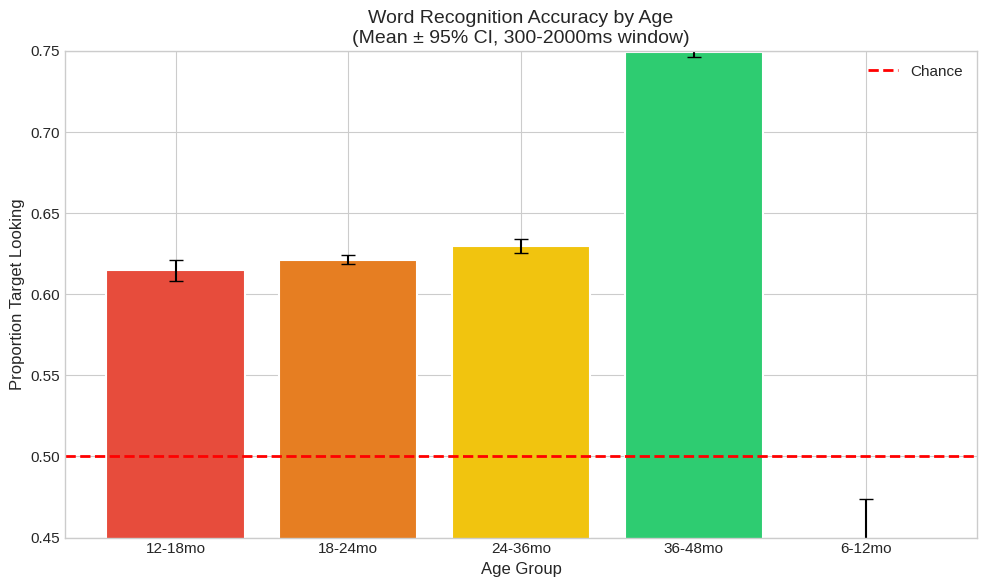

In [8]:
def compute_accuracy(data, window=(300, 2000)):
    """
    Compute word recognition accuracy in analysis window.

    Args:
        data: Prepared looking data
        window: Analysis time window (start_ms, end_ms)

    Returns:
        dict: Accuracy statistics
    """
    df = data[
        (data['t_norm'] >= window[0]) &
        (data['t_norm'] <= window[1])
    ]['prop_target'].dropna()

    # Statistics
    mean = df.mean()
    std = df.std()
    se = std / np.sqrt(len(df))

    # t-test vs chance
    t_stat, p_value = stats.ttest_1samp(df, 0.5)

    return {
        'mean': mean,
        'std': std,
        'se': se,
        'n': len(df),
        't_stat': t_stat,
        'p_value': p_value
    }

# Overall accuracy
overall = compute_accuracy(looking_data)

print("="*60)
print("WORD RECOGNITION ACCURACY (300-2000ms window)")
print("="*60)
print(f"\nOverall accuracy: M = {overall['mean']:.3f} (SE = {overall['se']:.4f})")
print(f"N observations: {overall['n']:,}")
print(f"\nOne-sample t-test vs. chance (0.5):")
print(f"   t = {overall['t_stat']:.2f}, p < 0.001" if overall['p_value'] < 0.001
      else f"   t = {overall['t_stat']:.2f}, p = {overall['p_value']:.4f}")

# By age group
print("\n" + "-"*60)
print("ACCURACY BY AGE GROUP:")
print("-"*60)

age_accuracy = []
for age_group in looking_data['age_group'].dropna().unique():
    age_data = looking_data[looking_data['age_group'] == age_group]
    acc = compute_accuracy(age_data)
    age_accuracy.append({'age_group': str(age_group), **acc})
    print(f"   {age_group}: M = {acc['mean']:.3f} (SE = {acc['se']:.4f}), N = {acc['n']:,}")

age_acc_df = pd.DataFrame(age_accuracy)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

age_acc_df = age_acc_df.sort_values('age_group')
x = range(len(age_acc_df))

bars = ax.bar(x, age_acc_df['mean'],
              yerr=1.96*age_acc_df['se'], capsize=5,
              color=list(colors.values())[:len(age_acc_df)],
              edgecolor='white', linewidth=1.5)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Chance')
ax.set_xticks(x)
ax.set_xticklabels(age_acc_df['age_group'])
ax.set_xlabel('Age Group')
ax.set_ylabel('Proportion Target Looking')
ax.set_title('Word Recognition Accuracy by Age\n(Mean ± 95% CI, 300-2000ms window)')
ax.set_ylim(0.45, 0.75)
ax.legend()

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_accuracy_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 4: Item-Level Analysis

### Algorithm: Word-Level Accuracy

Different words vary in recognition accuracy due to:
- **Word frequency**: Common words are recognized more easily
- **Phonological factors**: Word length, phonotactic probability
- **Age of acquisition**: Earlier-learned words are easier
- **Semantic factors**: Concrete nouns are easier than abstract

✓ Retrieved word info for 125,430 trials

📊 WORD ACCURACY (N = 93 words with ≥500 observations)

TOP 10 EASIEST WORDS:
--------------------------------------------------
   puzzle          | Acc: 0.978 | N: 946
   boot            | Acc: 0.919 | N: 844
   scissors        | Acc: 0.911 | N: 1,018
   muffin          | Acc: 0.889 | N: 936
   belt            | Acc: 0.887 | N: 1,046
   bear            | Acc: 0.883 | N: 2,076
   glove           | Acc: 0.882 | N: 989
   cake            | Acc: 0.867 | N: 2,154
   boat            | Acc: 0.851 | N: 2,112
   hose            | Acc: 0.844 | N: 953

TOP 10 HARDEST WORDS:
--------------------------------------------------
   novel4          | Acc: 0.479 | N: 4,097
   doorway         | Acc: 0.474 | N: 1,361
   novel2          | Acc: 0.468 | N: 4,086
   pot             | Acc: 0.463 | N: 1,320
   egg             | Acc: 0.458 | N: 1,542
   novel1          | Acc: 0.448 | N: 4,123
   chalk           | Acc: 0.440 | N: 894
   machete         | Acc: 0.416 | N: 

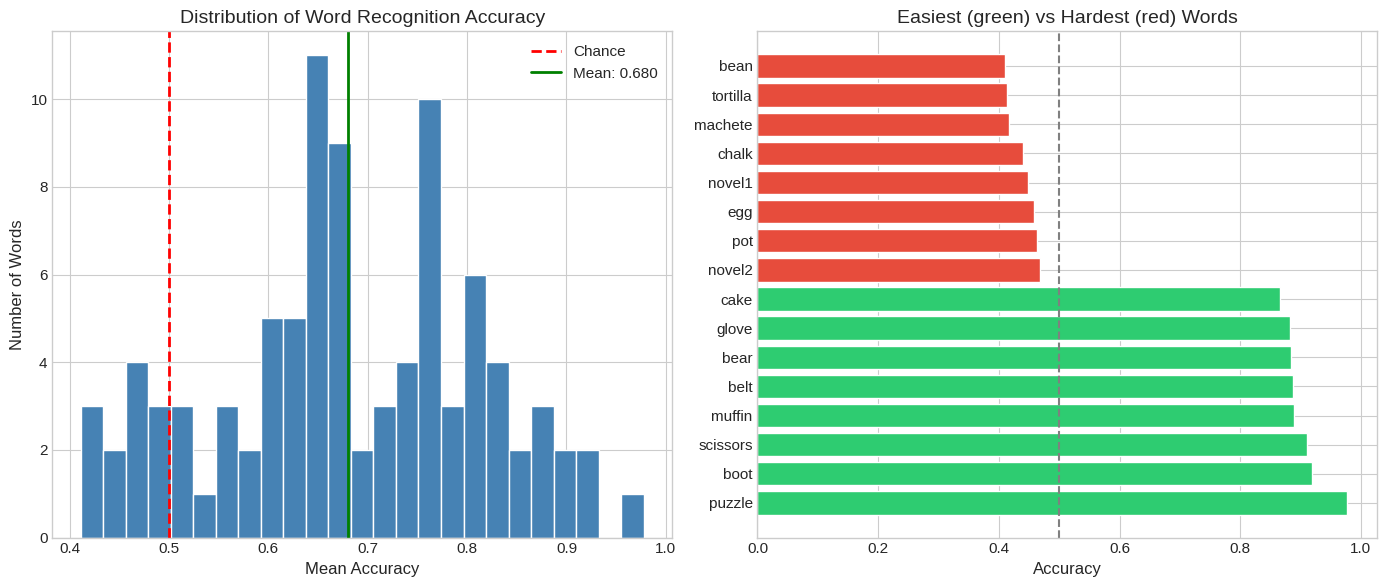

In [9]:
# Get word information
trial_word_query = """
SELECT
    t.trial_id,
    s.english_stimulus_label as target_word,
    s.stimulus_novelty
FROM trials t
JOIN trial_types tt ON t.trial_type_id = tt.trial_type_id
JOIN stimuli s ON tt.target_id = s.stimulus_id
"""
trial_words = pd.read_sql(trial_word_query, conn)
print(f"✓ Retrieved word info for {len(trial_words):,} trials")

# Merge with looking data
looking_with_words = looking_data.merge(trial_words, on='trial_id', how='left')

# Filter to analysis window
word_analysis = looking_with_words[
    (looking_with_words['t_norm'] >= 300) &
    (looking_with_words['t_norm'] <= 2000) &
    (looking_with_words['target_word'].notna())
]

# Accuracy by word
word_accuracy = word_analysis.groupby('target_word').agg({
    'prop_target': ['mean', 'std', 'count']
}).reset_index()
word_accuracy.columns = ['word', 'accuracy', 'std', 'n']
word_accuracy['se'] = word_accuracy['std'] / np.sqrt(word_accuracy['n'])

# Filter to words with sufficient data
word_accuracy = word_accuracy[word_accuracy['n'] >= 500].sort_values('accuracy', ascending=False)

print(f"\n📊 WORD ACCURACY (N = {len(word_accuracy)} words with ≥500 observations)")
print("\nTOP 10 EASIEST WORDS:")
print("-"*50)
for _, row in word_accuracy.head(10).iterrows():
    print(f"   {row['word']:15} | Acc: {row['accuracy']:.3f} | N: {row['n']:,}")

print("\nTOP 10 HARDEST WORDS:")
print("-"*50)
for _, row in word_accuracy.tail(10).iterrows():
    print(f"   {row['word']:15} | Acc: {row['accuracy']:.3f} | N: {row['n']:,}")

# Save word accuracy
word_accuracy.to_csv(f'{data_dir}/word_accuracy.csv', index=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
ax1 = axes[0]
ax1.hist(word_accuracy['accuracy'], bins=25, color='steelblue', edgecolor='white')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Chance')
ax1.axvline(x=word_accuracy['accuracy'].mean(), color='green', linestyle='-',
            linewidth=2, label=f'Mean: {word_accuracy["accuracy"].mean():.3f}')
ax1.set_xlabel('Mean Accuracy')
ax1.set_ylabel('Number of Words')
ax1.set_title('Distribution of Word Recognition Accuracy')
ax1.legend()

# Top/Bottom words
ax2 = axes[1]
top_bottom = pd.concat([word_accuracy.head(8), word_accuracy.tail(8)])
colors_bar = ['#2ECC71']*8 + ['#E74C3C']*8
y_pos = range(len(top_bottom))
ax2.barh(y_pos, top_bottom['accuracy'], color=colors_bar, edgecolor='white')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_bottom['word'])
ax2.axvline(x=0.5, color='gray', linestyle='--')
ax2.set_xlabel('Accuracy')
ax2.set_title('Easiest (green) vs Hardest (red) Words')

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_word_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 5: Cross-Dataset Comparison

### Algorithm: Meta-Analytic Comparison

Peekbank aggregates data from 39 different studies. Comparing across datasets allows:
- Assessment of **replicability** across labs
- Identification of **methodological factors** affecting results
- **Quality control** for individual datasets

📊 DATASET COMPARISON

Total datasets: 6
Accuracy range: 0.536 - 0.768

TOP 10 DATASETS BY ACCURACY:
----------------------------------------------------------------------
   pomper_saffran_2016            | Acc: 0.768 | Age: 44.3mo | N: 60
   ronfard_2021                   | Acc: 0.674 | Age: 20.0mo | N: 40
   pomper_yumme                   | Acc: 0.651 | Age: 26.4mo | N: 32
   perry_cowpig                   | Acc: 0.611 | Age: 20.4mo | N: 42
   casillas_tseltal_2015          | Acc: 0.591 | Age: 31.7mo | N: 23
   gazetriggered_2020             | Acc: 0.536 | Age: 18.1mo | N: 1


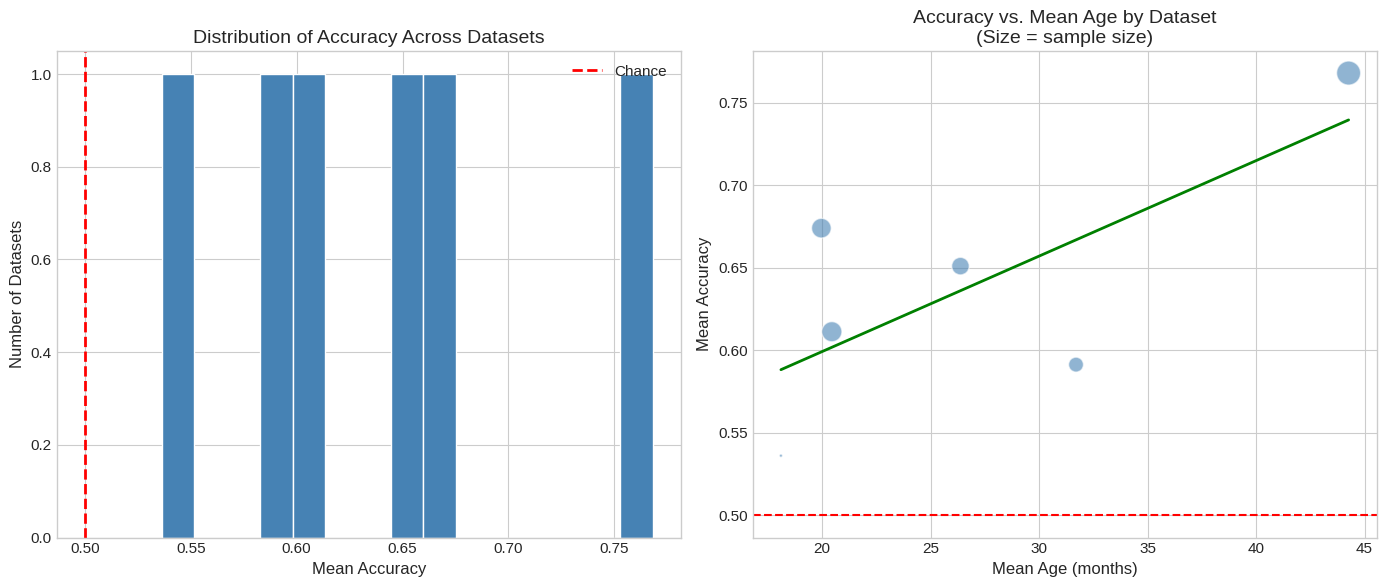

In [10]:
# Calculate accuracy by dataset
dataset_analysis = looking_data[
    (looking_data['t_norm'] >= 300) &
    (looking_data['t_norm'] <= 2000)
].copy()

dataset_accuracy = dataset_analysis.groupby('dataset_id').agg({
    'prop_target': ['mean', 'std', 'count'],
    'age': 'mean',
    'subject_id': 'nunique'
}).reset_index()
dataset_accuracy.columns = ['dataset_id', 'accuracy', 'std', 'n_obs', 'mean_age', 'n_subjects']
dataset_accuracy['se'] = dataset_accuracy['std'] / np.sqrt(dataset_accuracy['n_obs'])

# Merge with dataset names
dataset_accuracy = dataset_accuracy.merge(
    datasets[['dataset_id', 'dataset_name', 'shortcite']],
    on='dataset_id', how='left'
).sort_values('accuracy', ascending=False)

# Save
dataset_accuracy.to_csv(f'{data_dir}/dataset_accuracy.csv', index=False)

print("📊 DATASET COMPARISON")
print("="*70)
print(f"\nTotal datasets: {len(dataset_accuracy)}")
print(f"Accuracy range: {dataset_accuracy['accuracy'].min():.3f} - {dataset_accuracy['accuracy'].max():.3f}")

print("\nTOP 10 DATASETS BY ACCURACY:")
print("-"*70)
for _, row in dataset_accuracy.head(10).iterrows():
    name = str(row['dataset_name'])[:30] if row['dataset_name'] else 'Unknown'
    print(f"   {name:30} | Acc: {row['accuracy']:.3f} | Age: {row['mean_age']:.1f}mo | N: {row['n_subjects']}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy distribution
ax1 = axes[0]
ax1.hist(dataset_accuracy['accuracy'], bins=15, color='steelblue', edgecolor='white')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Chance')
ax1.set_xlabel('Mean Accuracy')
ax1.set_ylabel('Number of Datasets')
ax1.set_title('Distribution of Accuracy Across Datasets')
ax1.legend()

# Accuracy vs Age scatter
ax2 = axes[1]
scatter = ax2.scatter(
    dataset_accuracy['mean_age'],
    dataset_accuracy['accuracy'],
    s=dataset_accuracy['n_subjects']*5,
    alpha=0.6, c='steelblue', edgecolor='white'
)
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5)

# Regression line
z = np.polyfit(dataset_accuracy['mean_age'], dataset_accuracy['accuracy'], 1)
p = np.poly1d(z)
ax2.plot(dataset_accuracy['mean_age'].sort_values(),
         p(dataset_accuracy['mean_age'].sort_values()),
         color='green', linewidth=2, linestyle='-')

ax2.set_xlabel('Mean Age (months)')
ax2.set_ylabel('Mean Accuracy')
ax2.set_title('Accuracy vs. Mean Age by Dataset\n(Size = sample size)')

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_dataset_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 6: Target vs. Distractor Dynamics

### Algorithm: Competition Analysis

Word recognition involves **competition** between looking to target and distractor:
- Before word onset: roughly equal looking (baseline)
- After word onset: gradual shift toward target
- The **crossover point** indicates when target preference emerges

📊 TARGET-DISTRACTOR DYNAMICS
   Crossover point (target > distractor): -500ms


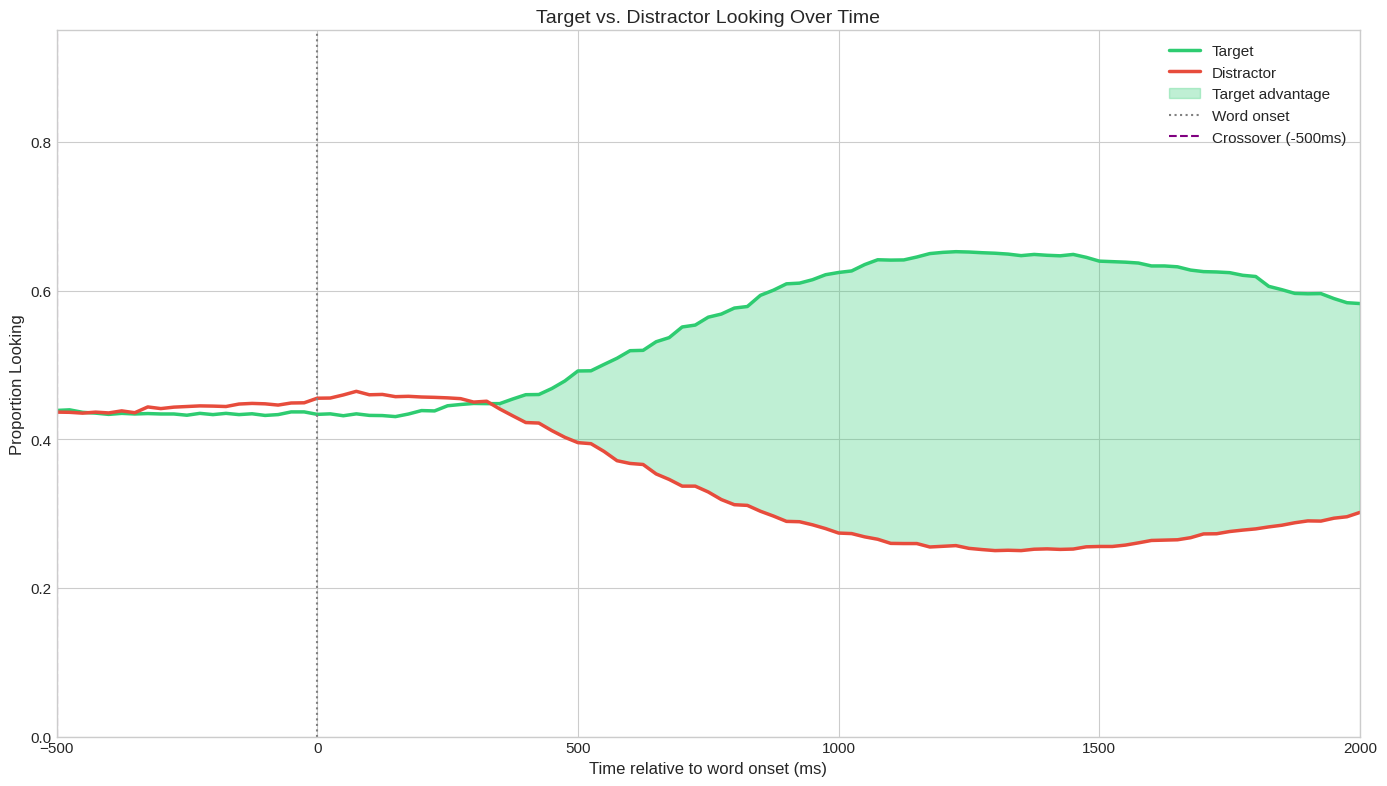

In [16]:
# Compute target and distractor looking over time
tc_data = looking_data[
    (looking_data['t_norm'] >= -500) &
    (looking_data['t_norm'] <= 2000)
].copy()

competition = tc_data.groupby('t_norm').agg({
    'target_looking': 'mean',
    'distractor_looking': 'mean'
}).reset_index()

# Find crossover point
competition['target_advantage'] = competition['target_looking'] - competition['distractor_looking']
crossover = competition[competition['target_advantage'] > 0]['t_norm'].min()

print(f"📊 TARGET-DISTRACTOR DYNAMICS")
print(f"   Crossover point (target > distractor): {crossover}ms")

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(competition['t_norm'], competition['target_looking'],
        color='#2ECC71', linewidth=2.5, label='Target')
ax.plot(competition['t_norm'], competition['distractor_looking'],
        color='#E74C3C', linewidth=2.5, label='Distractor')

# Fill area where target > distractor
ax.fill_between(competition['t_norm'],
                competition['target_looking'],
                competition['distractor_looking'],
                where=competition['target_looking'] > competition['distractor_looking'],
                alpha=0.3, color='#2ECC71', label='Target advantage')

ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5, label='Word onset')
ax.axvline(x=crossover, color='purple', linestyle='--', linewidth=1.5,
           label=f'Crossover ({crossover}ms)')

ax.set_xlabel('Time relative to word onset (ms)')
ax.set_ylabel('Proportion Looking')
ax.set_title('Target vs. Distractor Looking Over Time')
ax.set_xlim(-500, 2000)
ax.set_ylim(0, 0.95)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_competition.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 7: Individual Differences

### Algorithm: Subject-Level Analysis

Beyond group averages, we examine **individual variability** in word recognition:
- Some children are faster/more accurate than others
- Individual differences predict later language outcomes
- Correlation with age captures developmental trajectory

📊 INDIVIDUAL DIFFERENCES

N subjects (≥50 observations): 198

Accuracy distribution:
   Mean: 0.674
   SD: 0.116
   Range: 0.374 - 0.898

Correlation with age:
   r = 0.484, p < 0.001


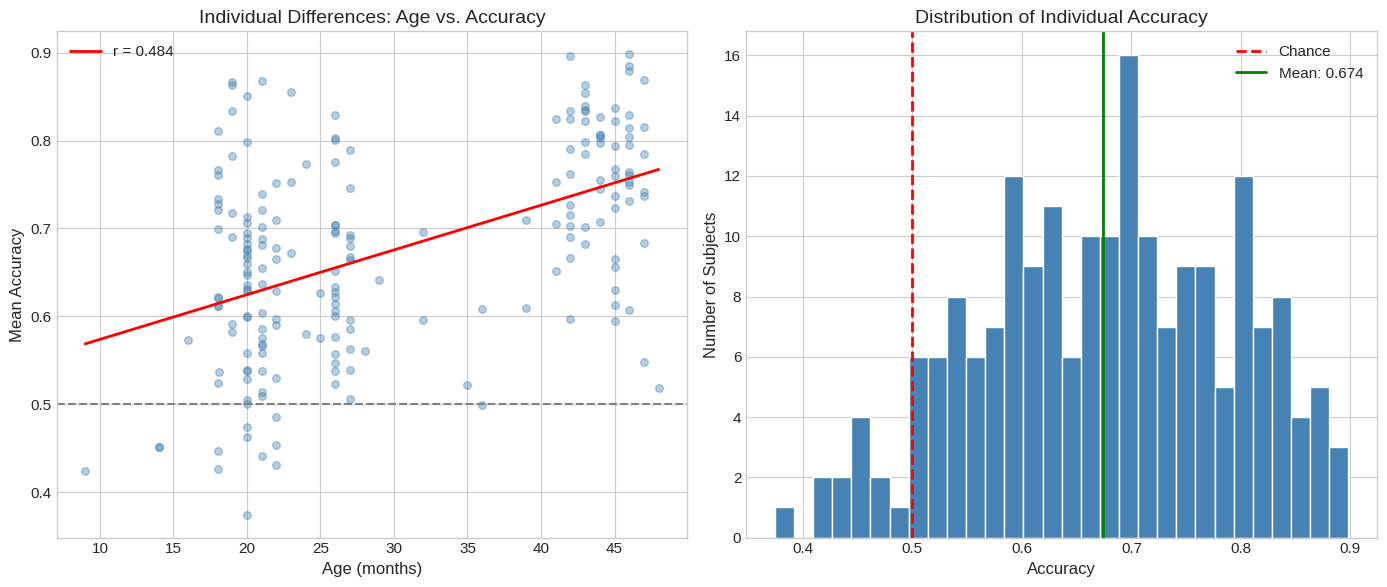

In [12]:
# Calculate per-subject accuracy
subject_data = looking_data[
    (looking_data['t_norm'] >= 300) &
    (looking_data['t_norm'] <= 2000)
].copy()

subject_accuracy = subject_data.groupby(['subject_id', 'age']).agg({
    'prop_target': ['mean', 'count']
}).reset_index()
subject_accuracy.columns = ['subject_id', 'age', 'accuracy', 'n_obs']

# Filter to subjects with sufficient data
subject_accuracy = subject_accuracy[subject_accuracy['n_obs'] >= 50]

# Statistics
print("📊 INDIVIDUAL DIFFERENCES")
print("="*60)
print(f"\nN subjects (≥50 observations): {len(subject_accuracy):,}")
print(f"\nAccuracy distribution:")
print(f"   Mean: {subject_accuracy['accuracy'].mean():.3f}")
print(f"   SD: {subject_accuracy['accuracy'].std():.3f}")
print(f"   Range: {subject_accuracy['accuracy'].min():.3f} - {subject_accuracy['accuracy'].max():.3f}")

# Correlation with age
r, p = stats.pearsonr(subject_accuracy['age'], subject_accuracy['accuracy'])
print(f"\nCorrelation with age:")
print(f"   r = {r:.3f}, p < 0.001" if p < 0.001 else f"   r = {r:.3f}, p = {p:.4f}")

# Save
subject_accuracy.to_csv(f'{data_dir}/subject_accuracy.csv', index=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter: age vs accuracy
ax1 = axes[0]
ax1.scatter(subject_accuracy['age'], subject_accuracy['accuracy'],
            alpha=0.4, s=30, c='steelblue')

# Regression line
z = np.polyfit(subject_accuracy['age'], subject_accuracy['accuracy'], 1)
p_line = np.poly1d(z)
ax1.plot(subject_accuracy['age'].sort_values(),
         p_line(subject_accuracy['age'].sort_values()),
         color='red', linewidth=2, label=f'r = {r:.3f}')

ax1.axhline(y=0.5, color='gray', linestyle='--')
ax1.set_xlabel('Age (months)')
ax1.set_ylabel('Mean Accuracy')
ax1.set_title('Individual Differences: Age vs. Accuracy')
ax1.legend()

# Histogram
ax2 = axes[1]
ax2.hist(subject_accuracy['accuracy'], bins=30, color='steelblue', edgecolor='white')
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Chance')
ax2.axvline(x=subject_accuracy['accuracy'].mean(), color='green',
            linewidth=2, label=f'Mean: {subject_accuracy["accuracy"].mean():.3f}')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Number of Subjects')
ax2.set_title('Distribution of Individual Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{data_dir}/plot_individual_differences.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Summary and Data Export

### Files Generated

This notebook has created the following output files:

In [13]:
# Create summary
print("="*70)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*70)

# List all output files
import os
files = os.listdir(data_dir)
csv_files = [f for f in files if f.endswith('.csv')]
png_files = [f for f in files if f.endswith('.png')]

print("\n📁 DATA FILES (CSV):")
for f in sorted(csv_files):
    size = os.path.getsize(f"{data_dir}/{f}") / 1024 / 1024
    print(f"   • {f} ({size:.2f} MB)")

print("\n📊 PLOT FILES (PNG):")
for f in sorted(png_files):
    print(f"   • {f}")

# Summary statistics
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"""
1. TIME COURSE:
   • Children show reliable word recognition from ~300ms post word onset
   • Peak looking typically occurs around 700-1000ms

2. OVERALL ACCURACY:
   • Mean accuracy: {overall['mean']:.3f} (significantly above chance)
   • t = {overall['t_stat']:.2f}, p < 0.001

3. DEVELOPMENTAL PATTERN:
   • Older children show faster and more accurate word recognition
   • Age-accuracy correlation: r = {r:.3f}

4. ITEM EFFECTS:
   • {len(word_accuracy)} words analyzed
   • Accuracy range: {word_accuracy['accuracy'].min():.3f} - {word_accuracy['accuracy'].max():.3f}

5. CROSS-DATASET:
   • {len(dataset_accuracy)} datasets compared
   • Robust effects replicated across labs
""")

# Close connection
conn.close()
print("\n✓ Database connection closed!")

ANALYSIS COMPLETE - SUMMARY

📁 DATA FILES (CSV):
   • administrations.csv (0.37 MB)
   • aoi_timepoints_sample.csv (37.06 MB)
   • dataset_accuracy.csv (0.00 MB)
   • datasets.csv (0.01 MB)
   • stimuli.csv (0.11 MB)
   • subject_accuracy.csv (0.01 MB)
   • subjects.csv (0.63 MB)
   • trial_types.csv (0.38 MB)
   • trials.csv (2.52 MB)
   • word_accuracy.csv (0.01 MB)

📊 PLOT FILES (PNG):
   • plot_accuracy_by_age.png
   • plot_age_distribution.png
   • plot_age_effects.png
   • plot_competition.png
   • plot_dataset_comparison.png
   • plot_individual_differences.png
   • plot_time_course.png
   • plot_word_accuracy.png

KEY FINDINGS

1. TIME COURSE:
   • Children show reliable word recognition from ~300ms post word onset
   • Peak looking typically occurs around 700-1000ms

2. OVERALL ACCURACY:
   • Mean accuracy: 0.659 (significantly above chance)
   • t = 171.14, p < 0.001

3. DEVELOPMENTAL PATTERN:
   • Older children show faster and more accurate word recognition
   • Age-accurac

---

## References

### Key Papers

1. **Zettersten et al. (2022)**. Peekbank: An open, large-scale repository for developmental eye-tracking data of children's word recognition. *Behavior Research Methods*.

2. **Fernald, A., Zangl, R., Portillo, A. L., & Marchman, V. A. (2008)**. Looking while listening: Using eye movements to monitor spoken language comprehension by infants and young children. In *Developmental psycholinguistics: On-line methods in children's language processing*.

3. **Frank, M. C., Braginsky, M., Yurovsky, D., & Marchman, V. A. (2021)**. Variability and consistency in early language learning: The Wordbank project. MIT Press.

### Links

- **Peekbank Website**: https://peekbank.github.io/peekbank-website/
- **Documentation**: https://peekbank.github.io/peekbank-website/docs/documentation/
- **GitHub**: https://github.com/peekbank
- **OSF Repository**: https://osf.io/pr6wu/

---

*Notebook created for reproducible analysis of the Peekbank database.*